# DSP Algorithm Prototyping

The objective of this notebook is to test your C-based VAD and DOA algorithm using Python. Instead of using the C language directly, the use of Python code can simplify:

* the generation of audio signals, 
* the import/export of audio file,
* the debugging of your C code (plotting, logging, ...)

In [1]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from numpy.ctypeslib import ndpointer
from scipy.io import wavfile

## Signal Model

The first objective is to synthesize a stereo random signal using Python. The considered signal is described by the following statistical model

\begin{align}
x_1[n] &= b[n]\\
x_2[n] &= b[n+\tau]
\end{align}

where 

* $b[n]\sim \mathcal{N}(0, \sigma^2)$ is a Gaussian noise with zero mean and variance $\sigma^2$. The noise is assumed white i.e. 

$$E[b[n]b[m]]=\sigma^2 \delta[n-m]=\left\{\begin{array}{cc} \sigma^2 &\text{ if }n=m\\
0 & \text{elsewhere}\end{array}\right.$$

* $\tau \in \mathbb{N}$ is the time delay between the left signal $x_1[n]$ and the right signal $x_2[n]$. 

##### Question [signal model]

* Create the stereo random signal model by implementing the `create_signal` function

In [2]:
def create_signal(tau, sigma, N, type = np.int16):
    """Create a stereo random signal using the white Gaussian noise model and return it using the int16 format"""
    X = np.zeros((2, N))
    # implement the signal model

    x1=np.random.normal(0,sigma,N)
    x2=np.roll(x1,tau)
    X=np.vstack((x1,x2))
    
    X = X.astype(type) 
    return X

The following code calls the `create_signal` and saves it in tne `wav` folder.

In [3]:
tau = 3    # samples
sigma = 2000
Fs = 16000  # Hz
N = 1600    # nombre d'échantillons
filename = "wav/noise.wav"

# Create the "wav" folder if it doesn't exist
#os.makedirs(os.path.dirname(filename), exist_ok=True)

X = create_signal(tau, sigma, N)
wavfile.write(filename, Fs, np.transpose(X))

## Python / C Interface

When your final objective is to implement a code in a uP, it is usually more direct to implement your algorithm using the C language. In this section, we show how to test your C code using Python. 

### DSP library

All the C codes are implemented in the `dsp.c` library. The `dsp` C library contains the definition of three functions :

* `print_pcm`: display the content of an audio signal,
* `compute_energy`: compute the energy of an audio signal, 
* `compute_xcorr`: compute the cross correlation of an stereo audio signal

These functions takes as inputs the the stereo audio signal encoded as a 1D array. The structure of the 1D array is provided below : 


| x_1[0] | x_2[0] | x_1[1] | x_2[1] | x_1[2] | x_2[2] | ... | x_1[M-1] | x_2[M-1] |
|---|---|---|---|---|---|---|---|---|


where the samples `x_l[n]` are encoded as `uint16_t` data.

The following Python function shows how to load a stereo wav file and format it as a 1D array of `uint16_t` data.

In [4]:
def load_audio2pcm(filename):
    """This function load a stereo audio file and convert the signal to a 1D signal with uint16 data type """
    Fs, X = wavfile.read(filename)
    x = np.ravel(X, order='C')  # convert 2D signal to 1D signal
    x = x.astype(np.uint16)  # convert to uint16 data
    return Fs, x

### Load the C Library

The C library can be compiled using the following command :

```
gcc -fPIC -shared dsp.c -o dsp.so
```

The following command should create the `dsp.so` file. The `dsp.so` file can be imported in a Python script using the `LoadLibrary` function.

In [5]:
# import C function
dsp = ctypes.cdll.LoadLibrary("./dsp.so")

## load functions
print_pcm = dsp.print_pcm
print_pcm.restype = None
print_pcm.argtypes = [ndpointer(ctypes.c_uint16, flags="C_CONTIGUOUS"), ctypes.c_size_t]

compute_energy = dsp.compute_energy
compute_energy.restype = ctypes.c_float
compute_energy.argtypes = [ndpointer(ctypes.c_uint16, flags="C_CONTIGUOUS"), ctypes.c_size_t]

compute_xcorr = dsp.compute_xcorr
compute_xcorr.restype = ctypes.c_float
compute_xcorr.argtypes = [ndpointer(ctypes.c_uint16, flags="C_CONTIGUOUS"), ctypes.c_size_t, ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"), ctypes.c_size_t]

### Test your C Code

The following script loads a stereo sound file using the `load_audio2pcm` python code and prints the content of the audio signal using the `print_pcm` C function.

In [6]:
filename = "wav/noise.wav"
Fs, x = load_audio2pcm(filename)
#E = compute_energy()
print_pcm(x, 10)


* sample0: x=[2057,-2762]
* sample1: x=[-2251,-275]
* sample2: x=[-4456,-1198]
* sample3: x=[-1463,2057]
* sample4: x=[3228,-2251]


## VAD Detection

A simple VAD detector is based on the signal energy criterion :

$$\widehat{\epsilon}_l^2 = \frac{1}{N} \sum_{n=0}^{N-1} x_l^2[n]$$

### Theoretical Analysis

For the considered signal model, the theoretical value is equal to : 

$$\epsilon_l^2 = \frac{1}{N}\sum_{n=0}^{N-1} E[x_l^2[n]] = \frac{1}{N}\sum_{n=0}^{N-1} \sigma^2 = \sigma^2 $$


In [7]:
energy_theo = sigma**2
print("theoretical value: energy={} joules".format(energy_theo))

theoretical value: energy=4000000 joules


### Implementation of the C function

##### Question [compute_energy]

* In the `dsp.c` file, implement the C function `compute_energy`,
* compare the estimated energy with its theoretical value. 

In [8]:
energy_est = compute_energy(x, len(x))
print("estimated value: energy={} joules".format(energy_est))

estimated value: energy=4214976.5 joules


## DOA Estimation

A simple DOA estimator is based on the maximum of the cross correlation. The cross correlation is defined as :

$$\widehat{R}[m] = \frac{1}{N} \sum_{n=0}^{N-1}x_1[n]x_2[n+m]$$

### Theoretical Analysis

For the considered signal model, the cross correlation is theoretically equal to 

\begin{align}
R[m] = \frac{1}{N} \sum_{n=0}^{N-1}E[x_1[n]x_2[n+m]]= \left\{\begin{array}{cc}
\sigma^2 &\text{ if }m=\tau\\
0 &\text{elsewhere}
\end{array}\right .
\end{align}

Text(0.5, 0, 'tau [sample]')

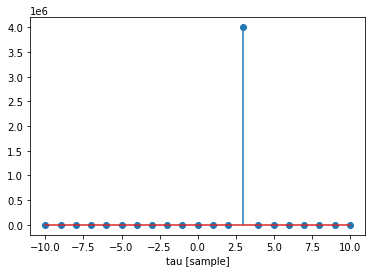

In [9]:
tau_max = 10
N_R = 2*tau_max+1
tau_vect = np.arange(-tau_max, tau_max+1)
R_theo = np.zeros(N_R)
R_theo[tau_max+tau] = sigma**2

plt.stem(tau_vect, R_theo)
plt.xlabel("tau [sample]")

### Implementation of the C function

##### Question [compute_xcorr]

* In the `dsp.c` file, implement the C function `compute_xcorr`,
* compare the estimated correlation with its theoretical values.

[ 2.5395795e+04  1.0277822e+05 -3.0393945e+04 -8.8081867e+04
  2.2665932e+04  8.9738373e+02 -1.7909722e+05 -1.4635408e+05
 -5.6513843e+03 -1.1346317e+05  6.5630164e+04 -1.6631000e+04
  1.4606512e+05  4.2149835e+06  1.4606516e+05 -1.6631006e+04
  6.5630148e+04 -1.1346318e+05 -5.6513667e+03 -1.4635408e+05
 -1.7909742e+05]


<StemContainer object of 3 artists>

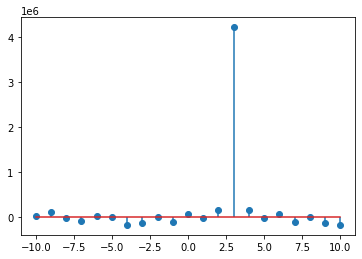

In [10]:
R_est = np.zeros(N_R, dtype=np.float32)
compute_xcorr(x, len(x), R_est, N_R)
print(R_est)
plt.stem(tau_vect,R_est)